In [19]:
from glob import glob
import utils
import pandas as pd
from collections import defaultdict
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.pyplot import subplots_adjust
from matplotlib.ticker import MaxNLocator
import os
%matplotlib inline


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [20]:
os.makedirs("figures", exist_ok=True)

In [21]:
df_results = pd.read_csv("../data/results.csv")
df_results.training_client_ids = df_results.training_client_ids.apply(eval)
df_results.head()

,accuracy,classification_time,host,method,name,output_dir,test_client_id,training_client_ids,host_label
0,97.714286,9.718208,www.mayoclinic.org,LL,train_one_test_one,../data/scenarios2/69/train_one_test_one_LL_ww...,6,[6],Mayo\nClinic
1,41.714286,99.014383,www.bankofamerica.com,Wfin,train_one_test_one,../data/scenarios2/69/train_one_test_one_Wfin_...,17,[9],Bank of\nAmerica
2,100.000000,10.797168,www.bankofamerica.com,PS,train_one_test_one,../data/scenarios2/69/train_one_test_one_PS_ww...,4,[4],Bank of\nAmerica
3,50.285714,76.695425,www.wellsfargo.com,CUMUL,train_one_test_one,../data/scenarios2/69/train_one_test_one_CUMUL...,13,[13],Wells\nFargo
4,8.285714,15.580510,www.plannedparenthood.org,IPS,train_one_test_one,../data/scenarios2/69/train_one_test_one_IPS_w...,2,[6],Planned\nParenthood


In [22]:
df_results.name.unique()

array(['train_one_test_one', 'test_one_train_remaining',
       'same_browser_21_training_samples', '6_browser'], dtype=object)

In [23]:
df_clients = pd.read_csv("../data/clients.csv",index_col=0)
client_id_to_info = df_clients.T.to_dict()
# client_id_to_info

In [24]:
df_train_one_test_one_results = df_results.dropna(subset=['accuracy']).query("name=='train_one_test_one'")
df_train_one_test_one_results['train_client_id'] = df_train_one_test_one_results.training_client_ids.apply(lambda x: x[0]) #we only have one train client, separate it

for i, row in df_train_one_test_one_results.iterrows():    
    client_train = client_id_to_info[row['train_client_id']]
    client_test  = client_id_to_info[row['test_client_id']]

    scenario = "unknown"
    if client_train == client_test:
        scenario = "Scenario 1"
    elif client_train['Browser'] == client_test['Browser'] and \
    client_train['OS'] == client_test['OS']:
        scenario = "Scenario 2"
    elif client_train['Browser'] == client_test['Browser'] and \
    client_train['OS'] != client_test['OS']:
        scenario = "Scenario 3"
    elif client_train['Browser'] != client_test['Browser'] and \
    client_train['OS'] == client_test['OS']:
        scenario = "Scenario 4"
    elif client_train['Browser'] != client_test['Browser'] and \
    client_train['OS'] != client_test['OS']:
        scenario = "Scenario 5"
        
    df_train_one_test_one_results.set_value(i, 'scenario', scenario)
# df_train_one_test_one_results.loc[df_train_one_test_one_results.method != "BoG", 'accuracy'] *= 100
df_train_one_test_one_results.groupby("method").size()

method
BoG      2527
CUMUL    2527
IPS      2527
KFP      2527
LL       2527
OPS      2527
PS       2527
Wfin     2527
dtype: int64

In [25]:
len(df_train_one_test_one_results)

20216

In [26]:
# import os
# for i in range(len(df_train_one_test_one_results)):
#     temp = utils.load_pickle(os.path.join(df_train_one_test_one_results.iloc[i]['output_dir'], "split.pickle"))
#     assert list(map(len, temp)) == [1050, 350, 1400]

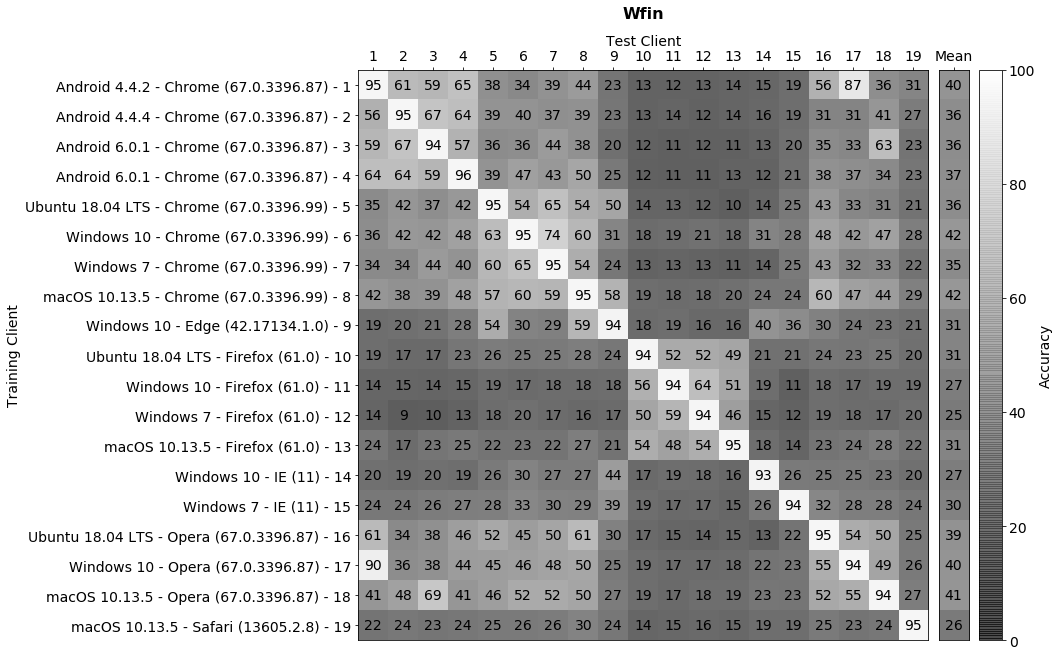

In [27]:
def plot_accuracy_matrix(df_train_one_test_one_results):
    num_clients = 19
    method_names = df_train_one_test_one_results.method.unique()
    method_names = ["Wfin"]
    for method_name in method_names:
        df_method_results = df_train_one_test_one_results.query("method=='{}'".format(method_name))
        accuracy_matrix = df_method_results.pivot_table(index="train_client_id", columns="test_client_id", values="accuracy").fillna(0).as_matrix()

        fig, ax = plt.subplots(figsize=(20,8))
        subplots_adjust(top = 0.99, bottom = 0, right = 0.85, left = 0.3, 
                    hspace = 0, wspace = 0.1)

        im = ax.imshow(accuracy_matrix, cmap=plt.cm.gray, vmin=0, vmax=100, alpha=0.7)
        for (i,j),label in np.ndenumerate(accuracy_matrix):
            if label == 0: continue
            ax.text(j,i,"{:.0f}".format(label),ha='center',va='center',size=14)

        #format axes
        _ = ax.set_xticks(range(num_clients))
        ax.set_xticklabels(range(1,num_clients+1), size=14)
        y_tick_labels = ["{} - {} - {}".format(x['OS'], x['Browser'], i) for i, x in client_id_to_info.items()]
        _ = ax.set_yticks(range(num_clients))
        ax.set_yticklabels(y_tick_labels,size=14)
        ax.xaxis.tick_top()
        ax.set_ylabel("Training Client", size=14)
        ax.set_xlabel("Test Client", size=14)
        ax.xaxis.set_label_position('top') 

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="4%", pad=0.7)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.set_ylabel('Accuracy', size=14)
        cbar.ax.tick_params(labelsize=14) 

        #add Mean column
        ax2 = fig.add_axes([0.315,0,.9,0.99])
        mean_accuracy = np.round(np.mean(accuracy_matrix,axis=1))
        mean_accuracy_column = mean_accuracy.reshape((19,1))
        im = ax2.imshow(mean_accuracy_column,cmap=plt.cm.gray, vmin=0, vmax=100, alpha=0.7)
        for (i,j),label in np.ndenumerate(mean_accuracy_column):
            if label == 0: continue
            ax2.text(j,i,"{:.0f}".format(label),ha='center',va='center',size=14)
        ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax2.set_yticks([])
        ax2.xaxis.tick_top()
        ax2.set_xticks([0])
        ax2.set_xticklabels(["Mean"],size=14)
        
        fig.savefig("figures/accuracy_matrix_{}.pdf".format(method_name),bbox_inches="tight")
        
        ax.set_title(method_name, size=16, y=1.08, weight="bold")
plot_accuracy_matrix(df_train_one_test_one_results)

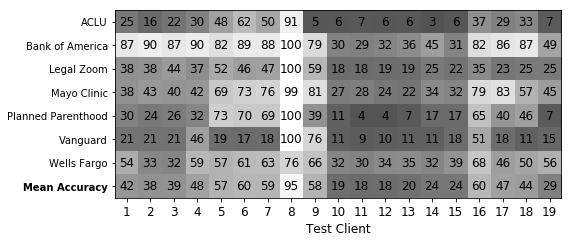

In [28]:
def plot_wfin_best_row(df_train_one_test_one_results):
    df_wfin_results = df_train_one_test_one_results.query("method=='Wfin'")
    best_training_client_id = df_wfin_results.groupby("train_client_id")['accuracy'].mean().argmax()
    best_training_client_id

    df_pivot = df_wfin_results.query("train_client_id=={}".format(best_training_client_id)).pivot_table(columns="test_client_id",index="host",values="accuracy")
    # df_pivot = df_wfin_results.query("method=='Wfin'").pivot_table(columns="test_client_id",index="host",values="accuracy")
    df_pivot.index = list(map(lambda x: utils.host_label[x].replace("\n"," "), df_pivot.index))
    df_pivot.sort_index(inplace=True)
    s_mean = df_pivot.mean()
    s_mean.name = "Mean Accuracy"
    df_pivot = df_pivot.append(s_mean)
    fig, ax = plt.subplots(figsize=(8,6))
    accuracy_matrix = df_pivot.as_matrix()
    im = ax.imshow(accuracy_matrix, cmap=plt.cm.gray, vmin=0, vmax=100, alpha=0.7) 
    for (j,i),label in np.ndenumerate(accuracy_matrix):
    #     ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
        ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
    ax.set_xlabel("Test Client",size=12)
    plt.xticks(range(19),range(1,20),size=12)
    yticks = plt.yticks(range(8), list(df_pivot.index))
    yticks[-1][-1].set_weight("bold")
    fig.savefig("figures/wfin_best_training_client_matrix.pdf",bbox_inches="tight")
plot_wfin_best_row(df_train_one_test_one_results)

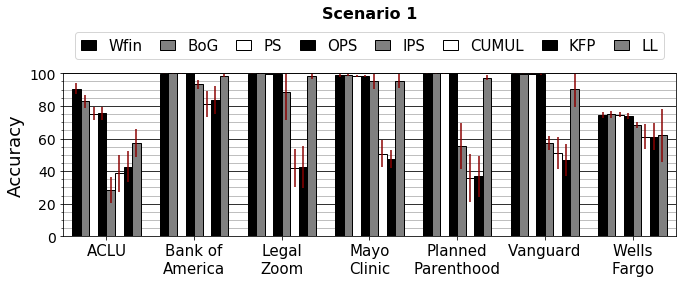

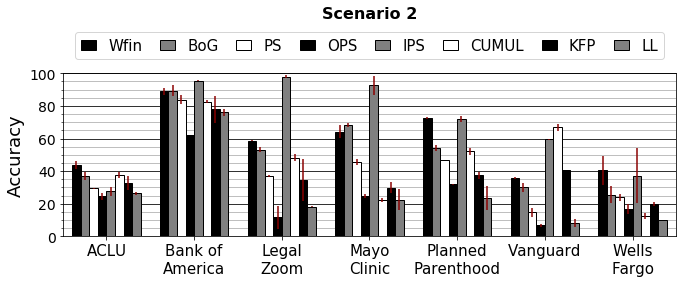

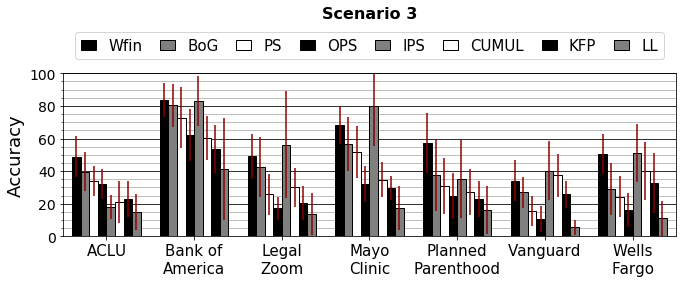

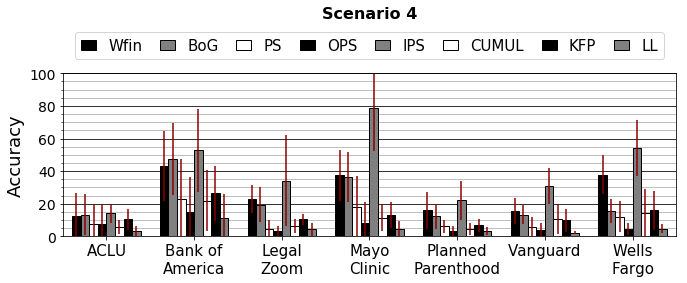

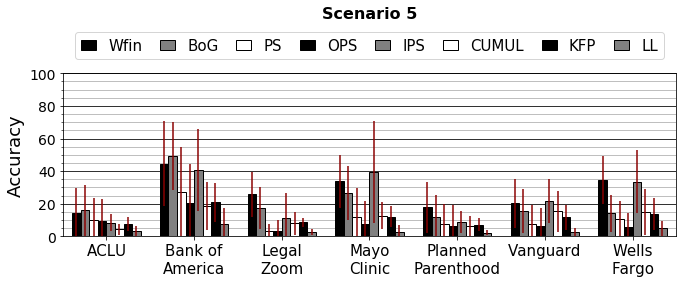

In [29]:
def plot_scenarios(df_train_one_test_one_results):
    for scenario in range(1,6):
        df_scenario_mean = df_train_one_test_one_results.query("scenario=='Scenario {}'".format(scenario)).pivot_table(index="host_label",columns="method",values="accuracy")
        df_scenario_std = df_train_one_test_one_results.query("scenario=='Scenario {}'".format(scenario)).pivot_table(index="host_label",columns="method",values="accuracy",aggfunc="std")

        df_scenario_mean = df_scenario_mean[['Wfin','BoG','PS','OPS','IPS','CUMUL','KFP','LL']]
        figure,ax = plt.subplots(figsize=(11,3))
        color = cm.gray(np.linspace(0,1,3))
        df_scenario_mean.plot(kind="bar",ax=ax,rot=0, edgecolor=['black'], 
                             ecolor='#8b0000', color=color, yerr=df_scenario_std, width=0.78)
        ax.grid(True, axis='y',color="black")
        ax.set_axisbelow(True)
        ax.minorticks_on()
        ax.set_xlabel("")
        ax.tick_params(axis='x',which='minor',bottom='off')
        ax.set_ylabel("Accuracy",size=18)
        ax.grid(which='minor',axis="y")
        plt.xticks(fontsize=15)
        plt.ylim((0,100))
        plt.xlim(-0.5,6.5)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=15, bbox_to_anchor=(0, 1.15, 1., .102), loc=9,
                   ncol=9, borderaxespad=0.,handlelength=1,columnspacing=1.2)
        figure.savefig(os.path.join("figures", "scenario_"+str(scenario)+".pdf"),bbox_inches="tight")
        ax.set_title("Scenario {}".format(scenario), size=16, y=1.3, weight="bold")
plot_scenarios(df_train_one_test_one_results)

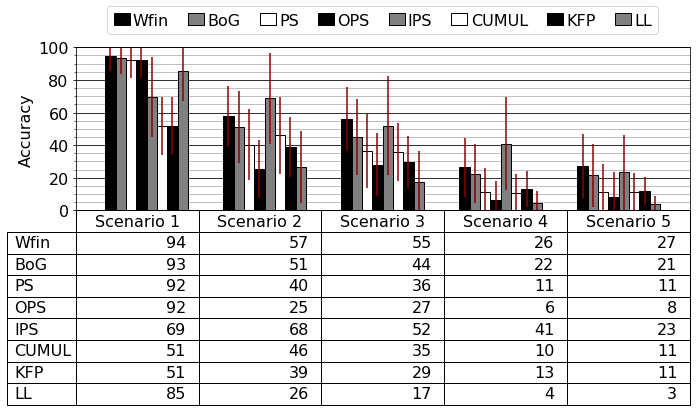

In [30]:
def plot_accuracy_table(df_train_one_test_one_results):
    df_scenario_method_mean = df_train_one_test_one_results.pivot_table(index="scenario", columns="method", values="accuracy",aggfunc="mean")
    df_scenario_method_mean = df_scenario_method_mean[['Wfin','BoG','PS','OPS','IPS','CUMUL','KFP','LL']]
    df_scenario_method_std = df_train_one_test_one_results.pivot_table(index="scenario", columns="method", values="accuracy", aggfunc="std")
    figure,ax = plt.subplots(figsize=(11,3))
    color = cm.gray(np.linspace(0,1,3))
    df_scenario_method_mean.plot(kind="bar", ax=ax,rot=0, edgecolor=['black'], 
                  color=color, yerr=df_scenario_method_std, ecolor='#8b0000',
                  width=0.7,
                  table=np.round(df_scenario_method_mean.T,1).astype(int))#colormap=cm.gray
    fontsize = 16
    ax.grid(True, axis='y',color="black")
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(which='minor',axis="y")
    ax.tick_params(axis='x',which='minor',bottom='off')
    ax.set_ylabel("Accuracy",size=fontsize)
    ax.set_xlabel("")
    plt.xticks([], fontsize=fontsize,weight='bold')
    plt.ylim((0,100))
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize, bbox_to_anchor=(0, 1.15, 1., .102), loc=9,
               ncol=9, borderaxespad=0.,handlelength=1,handletextpad=0.2,columnspacing=1.2)

    table = ax.tables[0]
    table.set_fontsize(fontsize)
    table.scale(1,1.8)
    figure.savefig("figures/scenarios_table.pdf",bbox_inches="tight")
plot_accuracy_table(df_train_one_test_one_results)

# **Test Using One Client - Train Using Remaining Clients**

# Figure 9

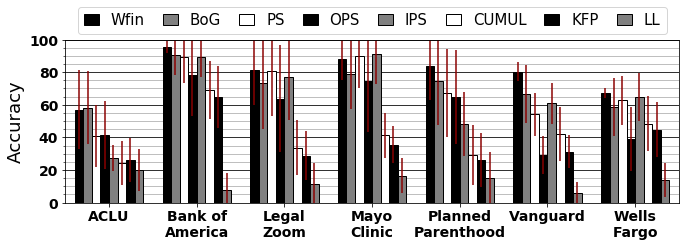

In [31]:
df_test_one_train_remaining = df_results.dropna(subset=['accuracy']).query("name=='test_one_train_remaining'")

def plot_test_one_train_remaining(df_test_one_train_remaining):
    df_host_method_std = df_test_one_train_remaining.pivot_table(index="host_label",columns="method", values="accuracy", aggfunc="std")
    df_host_method_mean = df_test_one_train_remaining.pivot_table(index="host_label", columns="method",  values="accuracy", aggfunc="mean")

    df_host_method_mean = df_host_method_mean[['Wfin','BoG','PS','OPS','IPS','CUMUL','KFP','LL']]

    figure = plt.figure(figsize=(11,3))
    ax = plt.subplot("111")

    # df_scenario = df_scenario[['BoG','CUMUL','KFP','Liberatore','PS','IPS','OPS']]
    #     color = cm.gray(np.linspace(0,0.9,len(df_scenario.columns)))
    color = cm.gray(np.linspace(0,1,3))
    df_host_method_mean.plot(kind="bar", ax=ax,rot=0, edgecolor=['black'], 
                     ecolor='#8b0000', color=color, yerr=df_host_method_std, width=0.78)#colormap=cm.gray
    ax.grid(True, axis='y')
    ax.set_axisbelow(True)

    ax.grid(True, axis='y',color="black")
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(which='minor',axis="y")
    ax.tick_params(axis='x',which='minor',bottom='off')

    ax.set_ylabel("Accuracy",size=18)
    ax.set_xlabel("")
    plt.xticks(fontsize=14,weight='bold')
    plt.ylim((0,100))
    plt.xlim(-0.5,6.5)
    plt.yticks(fontsize=14, weight='bold')
    plt.legend(fontsize=15, bbox_to_anchor=(0, 1.1, 1., .102), loc=9,
               ncol=9, borderaxespad=0.,handlelength=1,columnspacing=1.2) 
    figure.savefig("figures/sample_diversification_host_method_accuracy.pdf",bbox_inches="tight")
plot_test_one_train_remaining(df_test_one_train_remaining)

In [32]:
# import os
# for i in range(len(df_test_one_train_remaining)):
#     temp = utils.load_pickle(os.path.join(df_test_one_train_remaining.iloc[i]['output_dir'], "split.pickle"))
#     assert list(map(len, temp)) == [18900, 350, 19250]
# #     print(list(map(len, temp)))
# #     break

# Figure 10a

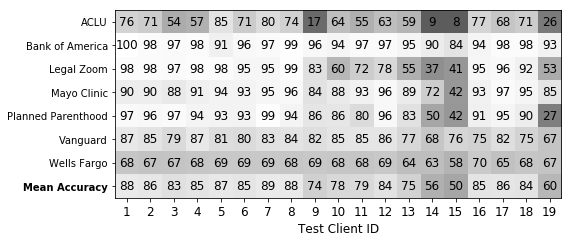

In [33]:
def plot_test_one_train_remaining_host_client_matrix(df_test_one_train_remaining):
    df_pivot = df_test_one_train_remaining.query("method=='Wfin'").pivot_table(columns="test_client_id",index="host_label",values="accuracy")
    df_pivot.index = list(map(lambda x: x.replace("\n"," "), df_pivot.index))
    df_pivot.sort_index(inplace=True)
    s_mean = df_pivot.mean()
    s_mean.name = "Mean Accuracy"
    df_pivot = df_pivot.append(s_mean)
    fig, ax = plt.subplots(figsize=(8,6))
    accuracy_matrix = df_pivot.as_matrix()
    im = ax.imshow(accuracy_matrix, cmap=plt.cm.gray, vmin=0, vmax=100, alpha=0.7) 
    for (j,i),label in np.ndenumerate(accuracy_matrix):
    #     ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
        ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
    ax.set_xlabel("Test Client ID",size=12)
    plt.xticks(range(19),range(1,20),size=12)
    yticks = plt.yticks(range(8), list(df_pivot.index))
    ytick = yticks[-1][-1]
    ytick.set_weight("bold")
    fig.savefig("figures/wfin_accuracy_matrix_test_one_train_remaining.pdf",bbox_inches="tight")
plot_test_one_train_remaining_host_client_matrix(df_test_one_train_remaining)

# **Train using Samples from 6 Different Browsers (10b)**

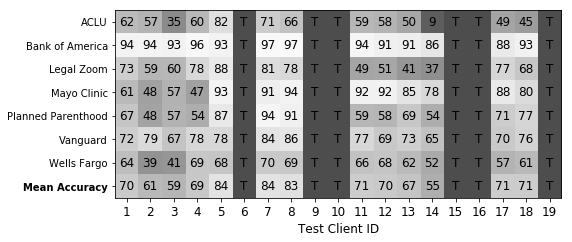

In [34]:
def plot_6_different_browser_matrix(df_wfin_6_different_browser_results):
    df_pivot = df_wfin_6_different_browser_results.pivot_table(columns="test_client_id",index="host_label",values="accuracy")
    df_pivot.index = list(map(lambda x: x.replace("\n"," "), df_pivot.index))
    for train_client_id in [6,9,10,15,16,19]:
        df_pivot[train_client_id] = -1
    df_pivot.sort_index(inplace=True,axis=1)
    df_pivot.sort_index(inplace=True)
    s_mean = df_pivot.mean()
    s_mean.name = "Mean Accuracy"
    df_pivot = df_pivot.append(s_mean)
    fig, ax = plt.subplots(figsize=(8,6))
    accuracy_matrix = df_pivot.as_matrix()
    im = ax.imshow(accuracy_matrix, cmap=plt.cm.gray, vmin=0, vmax=100, alpha=0.7) 
    for (j,i),label in np.ndenumerate(accuracy_matrix):
    #     ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
#         ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
        if label == -1: 
            ax.text(i,j,"T",ha='center',va='center',size=12)
        else:
            ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
    ax.set_xlabel("Test Client ID",size=12)
    plt.xticks(range(19),range(1,20),size=12)
    yticks = plt.yticks(range(8), list(df_pivot.index))
    ytick = yticks[-1][-1]
    ytick.set_weight("bold")
    fig.savefig("figures/6_clients_with_different_browsers.pdf",bbox_inches="tight")

df_wfin_6_different_browser_results = df_results.dropna(subset=["accuracy"]).query("method=='Wfin' and name=='6_browser'")
plot_6_different_browser_matrix(df_wfin_6_different_browser_results)

In [35]:
# import os
# for i in range(len(df_wfin_6_different_browser_results)):
#     temp = utils.load_pickle(os.path.join(df_wfin_6_different_browser_results.iloc[i]['output_dir'], "split.pickle"))
#     assert list(map(len, temp)) == [6300, 350, 6650]
# #     print(list(map(len, temp)))
# #     break

# **Train and test using same browser samples (Figure 10d)**

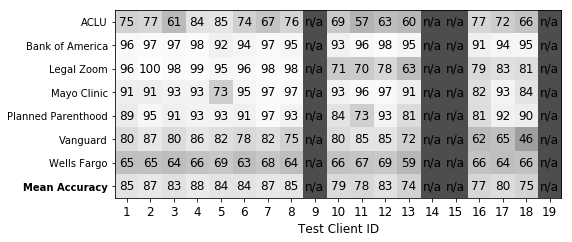

In [36]:
def plot_same_browser_matrix(df_same_browser_results):
    df_pivot = df_same_browser_results.pivot_table(columns="test_client_id",index="host_label",values="accuracy")
    df_pivot.index = list(map(lambda x: x.replace("\n"," "), df_pivot.index))
    for train_client_id in [9,14,15,19]:
        df_pivot[train_client_id] = -1
    df_pivot.sort_index(inplace=True,axis=1)
    df_pivot.sort_index(inplace=True)
    s_mean = df_pivot.mean()
    s_mean.name = "Mean Accuracy"
    df_pivot = df_pivot.append(s_mean)
    fig, ax = plt.subplots(figsize=(8,6))
    accuracy_matrix = df_pivot.as_matrix()
    im = ax.imshow(accuracy_matrix, cmap=plt.cm.gray, vmin=0, vmax=100, alpha=0.7) 
    for (j,i),label in np.ndenumerate(accuracy_matrix):
    #     ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
#         ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
        if label == -1: 
            ax.text(i,j,"n/a",ha='center',va='center',size=12)
        else:
            ax.text(i,j,"{:.0f}".format(label),ha='center',va='center',size=12)
    ax.set_xlabel("Test Client ID",size=12)
    plt.xticks(range(19),range(1,20),size=12)
    yticks = plt.yticks(range(8), list(df_pivot.index))
    ytick = yticks[-1][-1]
    ytick.set_weight("bold")
    fig.savefig("figures/wfin_same_browser_21_samples.pdf",bbox_inches="tight")

df_same_browser_results = df_results.dropna(subset=["accuracy"]).query("method=='Wfin' and name=='same_browser_21_training_samples'")
plot_same_browser_matrix(df_same_browser_results)